# <center> __Practical Assignment: Estimating VAR of a Portfolio.__

__Group Assignment:__
- *Ahmed Abdelazeem* (m20210433)
- *João Silva Ferreira* (m20210201)
- *Pedro Moura Gomes* (m20200322)
- *Omar Jarir* (m20201378)

## __The Problem:__

Consider a Russian investor holding a US and German stock portfolio on 09/03/2022.
Suppose that the investment is made in rubles and that:

> _60% of the portfolio is held in US stocks._

> _40% of the portfolio is held in German stocks._

The US portfolio has a $\beta$ of 1.6 relative to the NASDAQ index and the German portfolio has a $\beta$ of 1.3 relative to the DAX index.

In order to evaluate the portfolio risk, you are given the data from NASDAQ 100, DAX and EUR=RUB and USD=RUB exchange rates from 09/03/2017 to 09/03/2022.

Answer all the questions and explain your answers and choices on a report.

__Some Notes on the Formulation__

1. Note that, for instance, the price of a given US stock, in rubles, is the dollar price multiplied by
   the USD=RUB exchange rate, ie,

   \begin{align}
      P_{t}^{RUB}=P_{t}^{USD}X_{t}^{USD/RUB}
   \end{align}


   Hence, the log equity return and the log forex return are additive, ie,
   
   \begin{align}
 ln\left(\frac{P_{t+1}^{RUB}}{P_{t}^{RUB}}\right)&=ln\left(\frac{P_{t+1}^{USD}}{P_{t}^{USD}}\right)+ln\left(\frac{X_{t+1}^{USD/RUB}}{X_{t}^{USD/RUB}}\right)\Longleftrightarrow\\r_{t}^{RUB}&=r_{t}^{USD}+r_{t}^{USD/RUB}
  \end{align}
    

This means that the risk of a US stock portfolio to a Russian investor has an equity component,
based on the risk of the dollar returns on the portfolio and a forex component, which is based
on the USD=RUB foreign exchange rate.

2. Considering:

- $\omega_{1}$ the proportion of total capital invested in German market.
- $\omega_{2}$ the proportion of total capital invested in US market.
- $\ y_{1t}$ daily log returns on German index.
- $\ y_{2t}$ daily log returns on US index.
- $\ r_{t}^{RUB}$ daily log returns of the total portfolio, in rubles.
- $\ r_{1t}^{RUB}$ daily log returns on the German portfolio.
- $\ r_{2t}^{USD}$ daily log returns on the US portfolio.
- $\ r_{t}^{EUR/RUB}$ daily log returns of the forex rate EUR=RUB.
- $\ r_{t}^{USD/RUB}$ daily log returns of the forex rate USD=RUB.
- $\beta_{1}$ sensitivity of German stocks to DAX index.
- $\beta_{2}$ sensitivity of USD stocks to NASDAQ100.

We may notice that:

   \begin{align}
r_{t}^{RUB}&\simeq\omega_{1}r_{1t}^{RUB}+\omega r_{2t}^{RUB}\\&=\omega_{1}\left(r_{1t}^{EUR}+r_{t}^{EUR/RUB}\right)+\omega_{2}\left(r_{2t}^{USD}+r_{t}^{^{USD/RUB}}\right)\\&=\left(\omega_{1}\beta_{1}y_{1t}^{EUR}+\omega_{2}\beta_{2}y_{2t}^{USD}\right)+\left(\omega_{1}r_{t}^{EUR/RUB}+\omega_{2}r_{t}^{USD/RUB}\right)
  \end{align}

where:

- $\omega_{1}\beta_{1}y_{1t}^{EUR}+\omega_{2}\beta_{2}y_{2t}^{USD}$ corresponds to the net equity return of the portfolio
- $\omega_{1}r_{t}^{EUR/RUB}+\omega_{2}r_{t}^{USD/RUB}$ corresponds to the net forex return of the portfolio

__Importing the necessary libraries:__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import dates as mdates
from scipy.stats import norm
sns.set()

In [2]:
import time
t1 = time.perf_counter()

In [3]:
import warnings
warnings.filterwarnings("ignore")

__Loading the dataset.__

In [4]:
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/omarja12/Market_Risk/main/2122_RM_Data.xlsx"

data = rq.get(url).content

# Loading the dataset
ds = pd.read_excel(BytesIO(data))
# ds = pd.read_excel('2122_RM_Data.xlsx')

In [5]:
omega1 = 0.4 
omega2 = 0.6
beta1 = 1.3
beta2 = 1.6

In [6]:
# Converting the date to datetime.

ds['Date'] = pd.to_datetime(ds['Date'])

In [7]:
# Converting objects to float.

for c in ['DAX', 'NASDAQ100']:
    ds[c] = ds[c].apply(lambda x: x.replace(',', '')) 
    ds[c] = pd.to_numeric(ds[c])

In [8]:
# Sorting the dataframe by date.
ds = ds.sort_values(by="Date")

In [9]:
ds.reset_index(drop=True, inplace=True)

In [10]:
ds

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB
0,2017-02-09,11642.86,5212.16,61.9424,58.9600
1,2017-02-10,11666.97,5226.69,61.4520,58.2219
2,2017-02-13,11774.43,5256.82,60.4012,57.9851
3,2017-02-14,11771.81,5271.07,60.7171,57.1288
4,2017-02-15,11793.93,5302.39,61.4459,57.2565
...,...,...,...,...,...
1229,2022-03-03,13698.40,14035.21,117.6000,109.8960
1230,2022-03-04,13094.54,13837.83,118.9925,122.5375
1231,2022-03-07,12834.65,13319.38,118.9925,143.0000
1232,2022-03-08,12831.51,13267.61,118.9925,127.5000


___

# __Part 1:__

## __Question 1:__
    - Plot the evolution of both indexes and of the foreign exchange rates over the sample period.
    Comment.

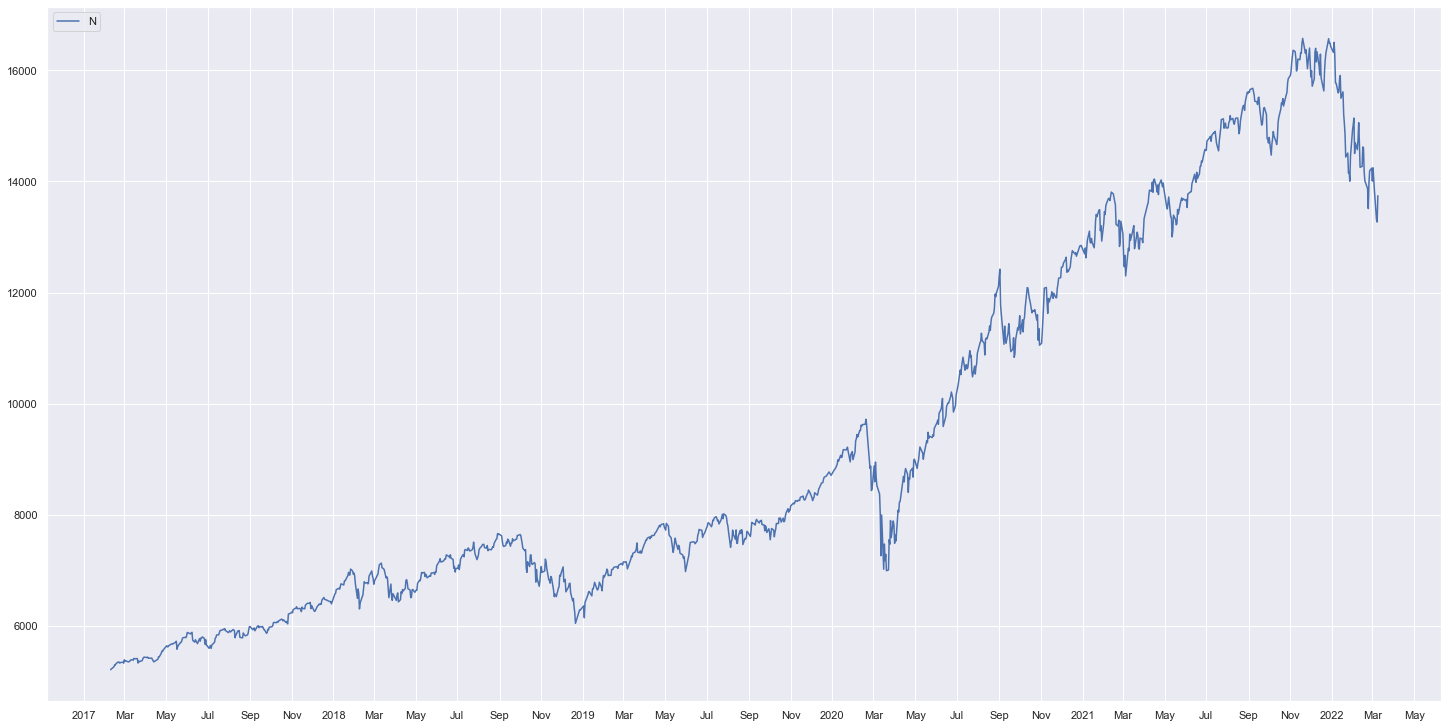

In [11]:
# Plotting the Nasdaq100 index.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds["NASDAQ100"]) 
ax.legend("NASDAQ100",loc="upper left")
fig.show();

We can see a decrease in the value of the NASDAQ100 index in February 2022.

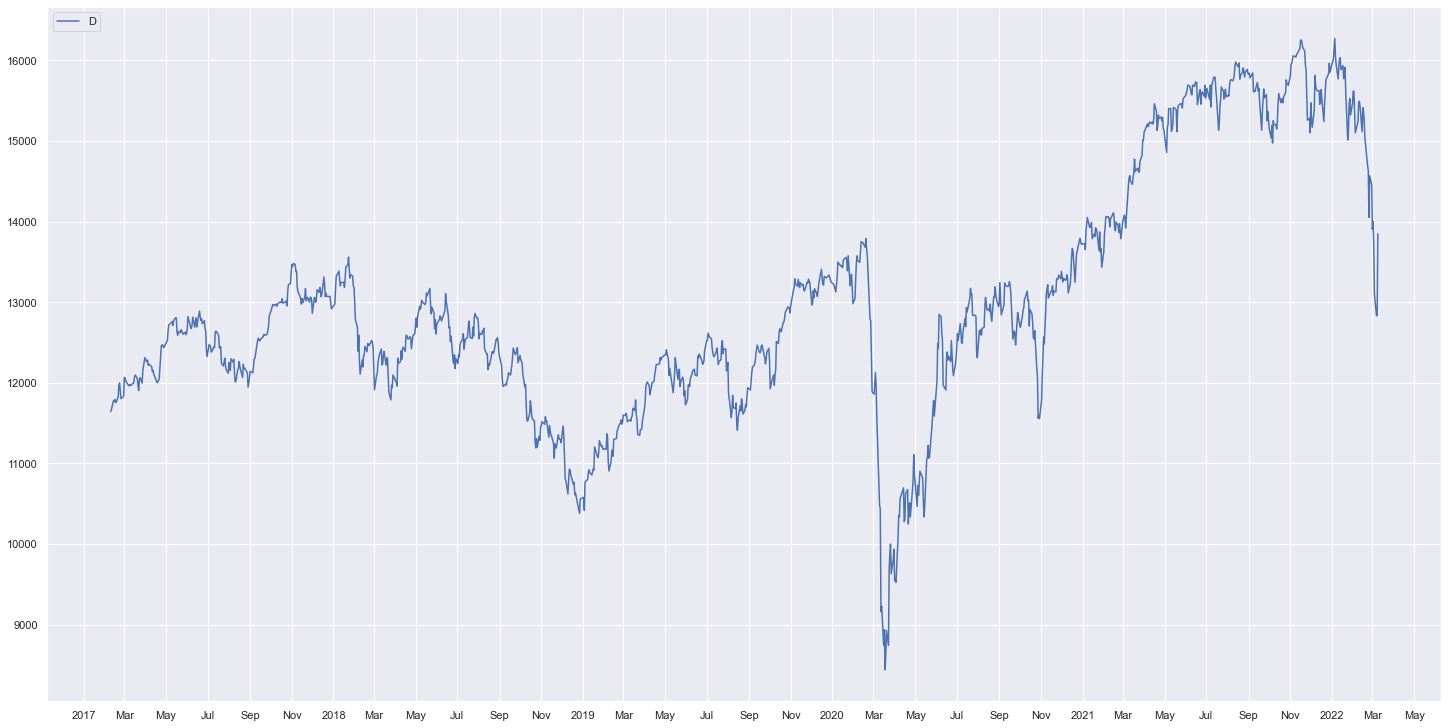

In [12]:
# Plotting the DAX index.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds["DAX"]) 
ax.legend("DAX",loc="upper left")
fig.show();

We can see a decrease in the value of the DAX index in February 2022.

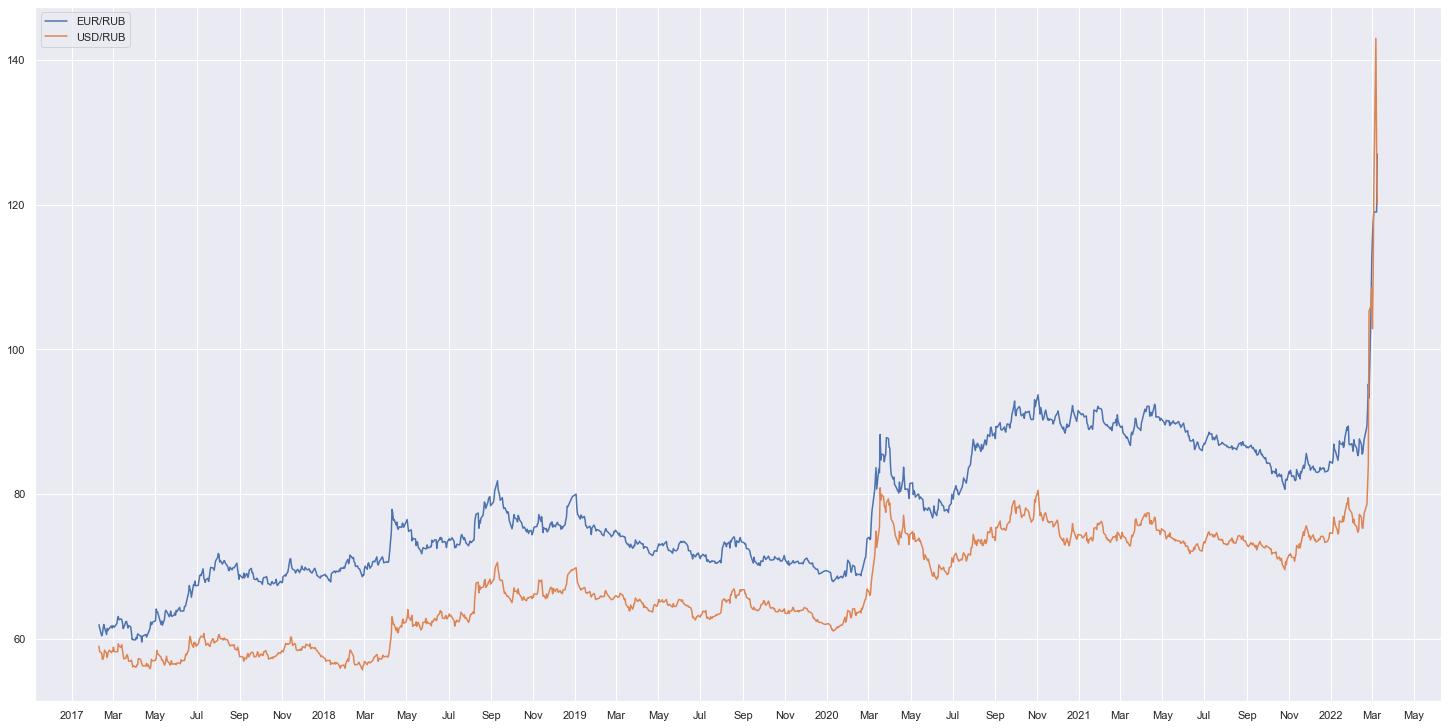

In [13]:
# Plotting the foreign exchange rate.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['EUR/RUB', 'USD/RUB']]) 
ax.legend(['EUR/RUB', 'USD/RUB'],loc="upper left")
fig.show();

From the plot above we can we that the exchange values of EUR/RUB and USD/RUB increase, meaning the rubble loses its value starting february 2022, which is the date of the Russian war on Ukraine.

## __Question 2:__
    - Express the DAX and NASDAQ100 values in rubles and plot them again. Comment.

In [14]:
ds['DAX_RUB'] = ds['DAX']*ds['EUR/RUB']
ds['NASDAQ100_RUB'] = ds['NASDAQ100']*ds['USD/RUB']

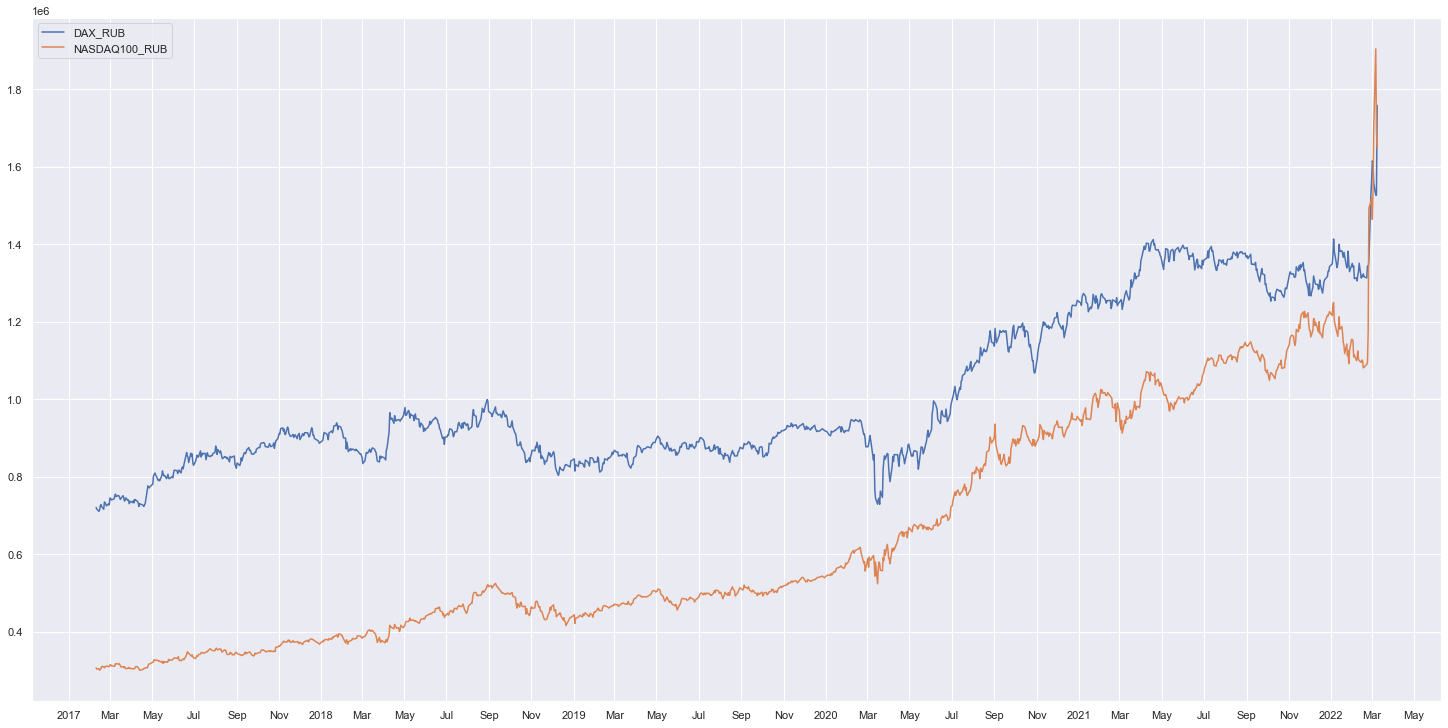

In [15]:
# Plotting the indexes in RUB.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['DAX_RUB', 'NASDAQ100_RUB']]) 
ax.legend(['DAX_RUB', 'NASDAQ100_RUB'],loc="upper left")
fig.show();

From the Plot above we can see that the value of indexes in RUB increases a lot in February 2022, on the date that coincides with the start of Russia war on Ukraine.

## __Question 3:__
    - Obtain the daily net equity returns and the daily net forex returns of the portfolio. Plot them
    and comment.

In [16]:
ds['y_1t'] = np.log1p(ds['DAX'].pct_change())
ds['y_1t'] = ds['y_1t'].fillna(0)

ds['y_2t'] = np.log1p(ds['NASDAQ100'].pct_change()) 
ds['y_2t'] = ds['y_2t'].fillna(0)

In [17]:
ds['rt_EUR/RUB'] = np.log1p(ds['EUR/RUB'].pct_change())
ds['rt_EUR/RUB'] = ds['rt_EUR/RUB'].fillna(0)

ds['rt_USD/RUB'] = np.log1p(ds['USD/RUB'].pct_change())
ds['rt_USD/RUB'] = ds['rt_USD/RUB'].fillna(0)

In [18]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233


In [19]:
ds['Forex_return'] = omega1*ds['rt_EUR/RUB'] + omega2*ds['rt_USD/RUB']

In [20]:
ds['Equity_return'] = omega1*beta1*ds['y_1t'] + omega2*beta2*ds['y_2t']

In [21]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Forex_return,Equity_return
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598,-0.010738,0.003748
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075,-0.009344,0.010286
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878,-0.006840,0.002483
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233,0.006112,0.006664


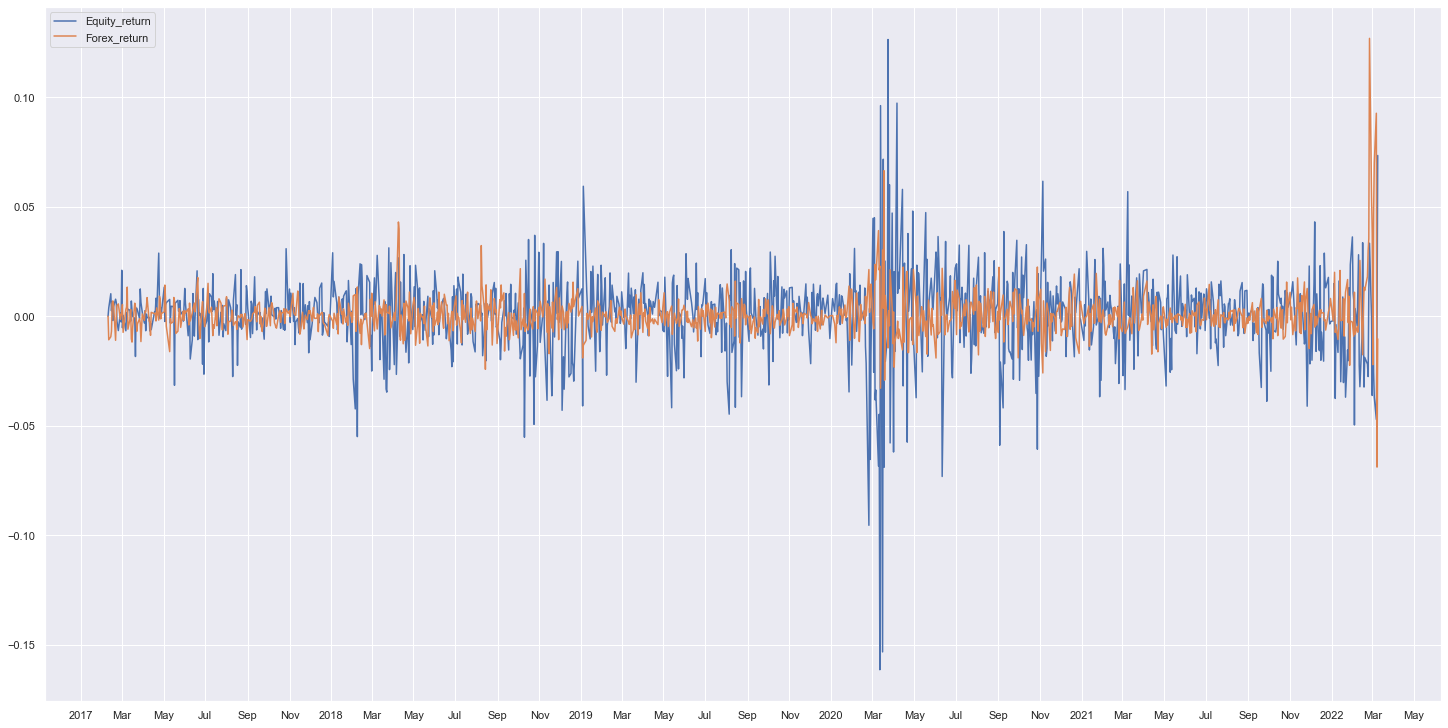

In [22]:
# Plotting the daily net equity and forex returns.

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[["Equity_return", "Forex_return"]]) 
ax.legend(["Equity_return", "Forex_return"],loc="upper left")
fig.show();

## __Question 4:__
    - Obtain the daily portfolio returns and plot them on an histogram. Comment on the shape of
    the distribution.

In [23]:
# The daily portfolio return is given by:
ds['rt_RUB'] = ds['Equity_return'] + ds['Forex_return']

In [24]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Forex_return,Equity_return,rt_RUB
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598,-0.010738,0.003748,-0.006990
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075,-0.009344,0.010286,0.000942
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878,-0.006840,0.002483,-0.004357
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233,0.006112,0.006664,0.012776


In [25]:
#ds['rt_RUB'].hist()

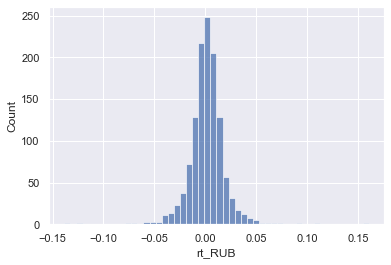

In [26]:
sns.histplot(data=ds, x='rt_RUB', bins=50)
plt.show();

In [27]:
print("The returns means is equal to:", ds["rt_RUB"].mean())
print("The returns standard deviation is equal to:", ds["rt_RUB"].std())

The returns means is equal to: 0.001405559555246771
The returns standard deviation is equal to: 0.01758189088056732


The distribution looks to normally distributed arround zero.

___

# __Part 2:__
    - Considering a smoothing parameter of lambda.

In [28]:
lbd=0.94  

## __Question 1:__:
    - The EWMA volatilities and correlations over the sample period for the net equity returns and
      forex returns.

In [29]:
ds['Equity_Adjusted_Variance'] = 0
ds['Equity_Adjusted_Variance'].iloc[0] = (ds['Equity_return']*ds['Equity_return']).mean()

ds['Forex_Adjusted_Variance'] = 0
ds['Forex_Adjusted_Variance'].iloc[0] = (ds['Forex_return']*ds['Forex_return']).mean()

In [30]:
# Class 3, page 30. I need to pay attention to this formula should we use r_t^2 or (r_t-1)^2

for i in range(1,ds.shape[0]):
    ds.loc[i, 'Equity_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'Equity_return']*ds.loc[i-1, 'Equity_return'] + lbd*ds.loc[i-1, 'Equity_Adjusted_Variance']
    ds.loc[i, 'Forex_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'Forex_return']*ds.loc[i-1, 'Forex_return'] + lbd*ds.loc[i-1, 'Forex_Adjusted_Variance']

In [31]:
ds['Equity_Adjusted Volatility'] = np.sqrt(ds['Equity_Adjusted_Variance'])
ds['Forex_Adjusted Volatility'] = np.sqrt(ds['Forex_Adjusted_Variance'])

In [32]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Forex_return,Equity_return,rt_RUB,Equity_Adjusted_Variance,Forex_Adjusted_Variance,Equity_Adjusted Volatility,Forex_Adjusted Volatility
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000340,0.000091,0.018434,0.009555
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598,-0.010738,0.003748,-0.006990,0.000319,0.000086,0.017873,0.009264
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075,-0.009344,0.010286,0.000942,0.000301,0.000088,0.017353,0.009359
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878,-0.006840,0.002483,-0.004357,0.000289,0.000088,0.017012,0.009358
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233,0.006112,0.006664,0.012776,0.000272,0.000085,0.016505,0.009226


- Now we need to estimate the correlations.

In [33]:
ds['Covariance'] = 0

ds['Covariance'].iloc[0] = (ds['Forex_return']*ds['Equity_return']).mean()

In [34]:
# Class 3, page:31

for i in range(1,ds.shape[0]):   
    ds.loc[i, 'Covariance'] = (1-lbd)*ds.loc[i-1, 'Forex_return']*ds.loc[i-1, 'Equity_return']  + lbd*ds.loc[i-1, 'Covariance']   

In [35]:
ds.head()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Forex_return,Equity_return,rt_RUB,Equity_Adjusted_Variance,Forex_Adjusted_Variance,Equity_Adjusted Volatility,Forex_Adjusted Volatility,Covariance
0,2017-02-09,11642.86,5212.16,61.9424,58.9600,721186.691264,307308.953600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000340,0.000091,0.018434,0.009555,-0.000060
1,2017-02-10,11666.97,5226.69,61.4520,58.2219,716958.640440,304307.822511,0.002069,0.002784,-0.007949,-0.012598,-0.010738,0.003748,-0.006990,0.000319,0.000086,0.017873,0.009264,-0.000057
2,2017-02-13,11774.43,5256.82,60.4012,57.9851,711189.701316,304817.233382,0.009168,0.005748,-0.017247,-0.004075,-0.009344,0.010286,0.000942,0.000301,0.000088,0.017353,0.009359,-0.000056
3,2017-02-14,11771.81,5271.07,60.7171,57.1288,714750.164951,301129.903816,-0.000223,0.002707,0.005216,-0.014878,-0.006840,0.002483,-0.004357,0.000289,0.000088,0.017012,0.009358,-0.000058
4,2017-02-15,11793.93,5302.39,61.4459,57.2565,724688.643387,303596.293035,0.001877,0.005924,0.011932,0.002233,0.006112,0.006664,0.012776,0.000272,0.000085,0.016505,0.009226,-0.000056


In [36]:
ds['Correlation'] = ds['Covariance']/(ds['Equity_Adjusted Volatility']*ds['Forex_Adjusted Volatility'])

In [37]:
ds.tail()

,Date,DAX,NASDAQ100,EUR/RUB,USD/RUB,DAX_RUB,NASDAQ100_RUB,y_1t,y_2t,rt_EUR/RUB,rt_USD/RUB,Forex_return,Equity_return,rt_RUB,Equity_Adjusted_Variance,Forex_Adjusted_Variance,Equity_Adjusted Volatility,Forex_Adjusted Volatility,Covariance,Correlation
1229,2022-03-03,13698.40,14035.21,117.6000,109.8960,1.610932e+06,1.542413e+06,-0.021786,-0.014745,0.018885,0.066258,0.047309,-0.025484,0.021825,0.000531,0.001263,0.023034,0.035537,-0.000018,-0.022177
1230,2022-03-04,13094.54,13837.83,118.9925,122.5375,1.558152e+06,1.695653e+06,-0.045084,-0.014163,0.011771,0.108883,0.070038,-0.037040,0.032998,0.000538,0.001321,0.023188,0.036351,-0.000089,-0.106063
1231,2022-03-07,12834.65,13319.38,118.9925,143.0000,1.527227e+06,1.904671e+06,-0.020047,-0.038186,0.000000,0.154428,0.092657,-0.047083,0.045574,0.000588,0.001536,0.024243,0.039197,-0.000240,-0.252235
1232,2022-03-08,12831.51,13267.61,118.9925,127.5000,1.526853e+06,1.691620e+06,-0.000245,-0.003894,0.000000,-0.114728,-0.068837,-0.003866,-0.072703,0.000685,0.001959,0.026182,0.044264,-0.000487,-0.420273
1233,2022-03-09,13847.93,13742.20,127.0000,120.0000,1.758687e+06,1.649064e+06,0.076232,0.035146,0.065127,-0.060625,-0.010324,0.073380,0.063056,0.000645,0.002126,0.025402,0.046110,-0.000442,-0.377260


## __Question 2:__
    - Calculating the adjusted portfolios returns, and comparing them with the original ones.

In [38]:
# Class 4, page:18.

ds['Adjusted_Equity_return'] = ds['Equity_return'] \
                *(ds.loc[ds.shape[0]-1, 'Equity_Adjusted Volatility']/ds['Equity_Adjusted Volatility'])

ds['Adjusted_Forex_return'] = ds['Forex_return'] \
                *(ds.loc[ds.shape[0]-1, 'Forex_Adjusted Volatility']/ds['Forex_Adjusted Volatility'])

Comparing the returns, and commenting. 

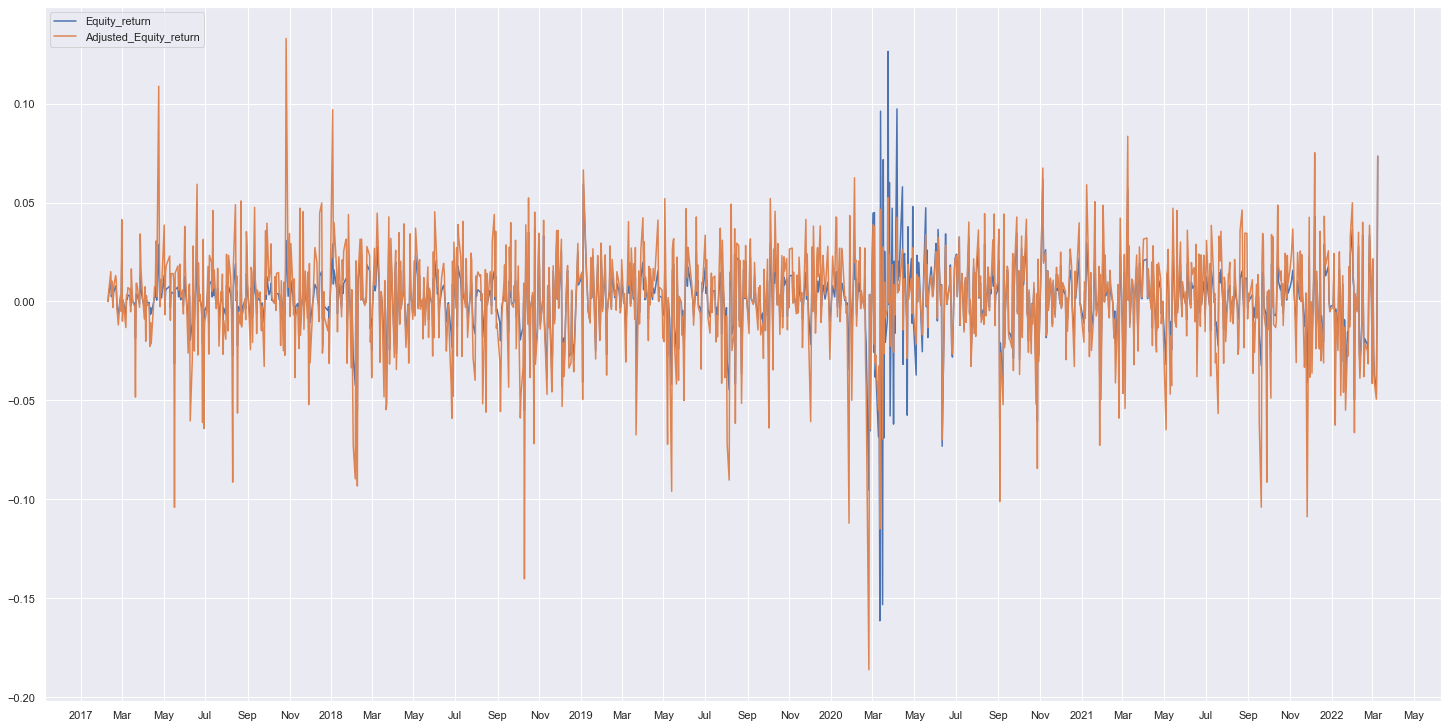

In [39]:
# Plotting and comparing "Equity_return" and "Adjusted_Equity_return".

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['Equity_return', 'Adjusted_Equity_return']]) 
ax.legend(['Equity_return', 'Adjusted_Equity_return'],loc="upper left")
fig.show();

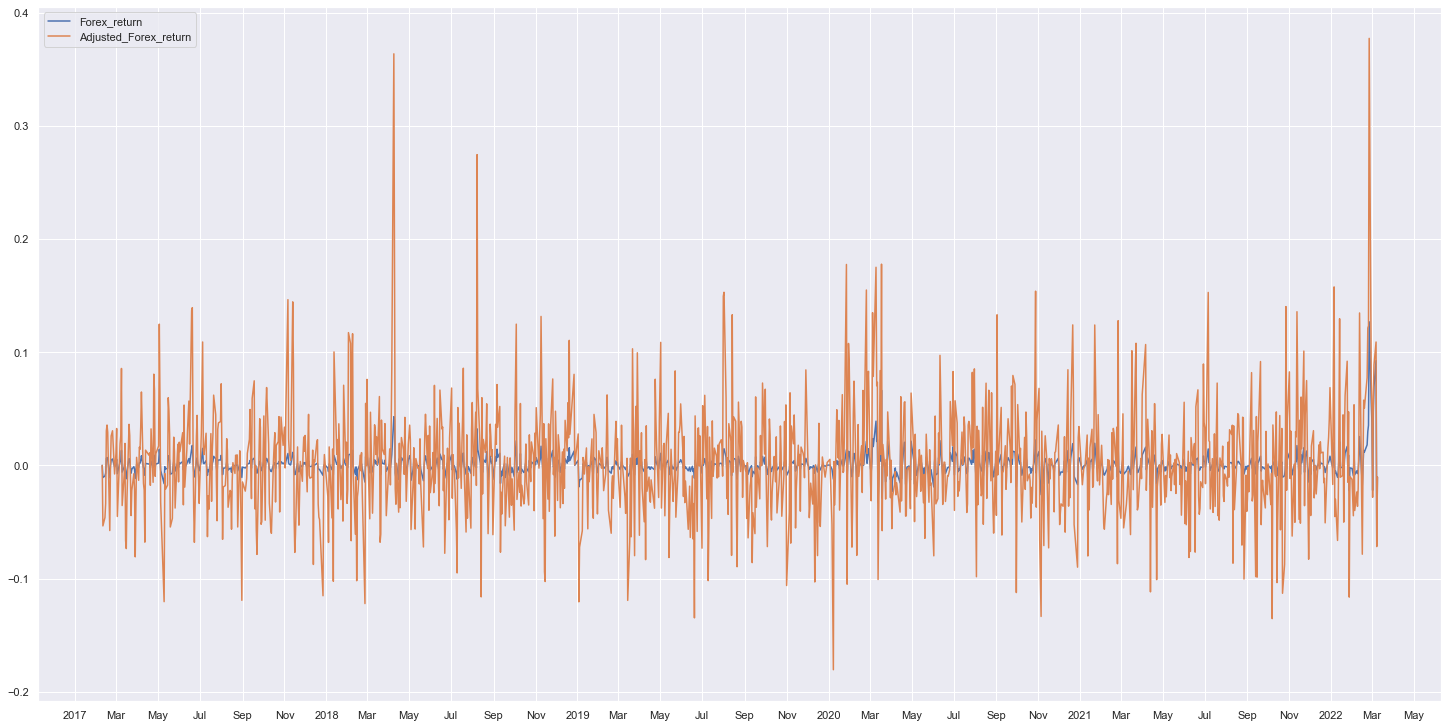

In [40]:
# Plotting and comparing "Forex_return" and "Adjusted_Forex_return".

fig, ax=plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
plt.rcParams['date.converter'] = 'concise'
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

ax.plot(ds['Date'], ds[['Forex_return', 'Adjusted_Forex_return']]) 
ax.legend(['Forex_return', 'Adjusted_Forex_return'],loc="upper left")
fig.show();

We can see that the adjusted returns are more volatile that original returns.

## __Question 3:__
    - Estimate the EWMA annual covariance matrix of the portfolio on 09/03/2022. Compare to the
      obtained from data at 23/02/2022. Comment.

In [41]:
trading_days=250

__On 09/03/2022, we have:__

The Annual volatility Nasdaq100 and Dax are given by: 

In [42]:
Equity_Annual_vol_09 = np.sqrt(trading_days)*ds.loc[ds.shape[0]-1, 'Equity_Adjusted Volatility']
Forex_Annual_vol_09 = np.sqrt(trading_days)*ds.loc[ds.shape[0]-1, 'Forex_Adjusted Volatility']
Correlation_09 = ds.loc[ds.shape[0]-1, 'Correlation']

In [43]:
a12 = Equity_Annual_vol_09*Forex_Annual_vol_09*Correlation_09
a11 = Equity_Annual_vol_09*Equity_Annual_vol_09
a22 = Forex_Annual_vol_09*Forex_Annual_vol_09

Annual_Covariance_Matrix_09 = np.matrix([[a11, a12], [a12, a22]])

In [44]:
pd.DataFrame(Annual_Covariance_Matrix_09, columns =["Equity", "Forex"], index=["Equity", "Forex"])

,Equity,Forex
Equity,0.161312,-0.110467
Forex,-0.110467,0.531522


__On the 23/02/2022, we have:__

In [45]:
Equity_Annual_vol_23 = np.sqrt(trading_days)*ds[ds['Date'] == '2022-02-23']['Equity_Adjusted Volatility'].values[0]
Forex_Annual_vol_23 = np.sqrt(trading_days)*ds[ds['Date'] == '2022-02-23']['Forex_Adjusted Volatility'].values[0]
Correlation_23 = ds[ds['Date'] == '2022-02-23']['Correlation'].values[0]

In [46]:
a12 = Equity_Annual_vol_23*Forex_Annual_vol_23*Correlation_23
a11 = Equity_Annual_vol_23*Equity_Annual_vol_23
a22 = Forex_Annual_vol_23*Forex_Annual_vol_23

Annual_Covariance_Matrix_23 = np.matrix([[a11, a12], [a12, a22]])

In [47]:
pd.DataFrame(Annual_Covariance_Matrix_23, columns=["Equity", "Forex"],index=["Equity", "Forex"])

,Equity,Forex
Equity,0.122700,-0.038781
Forex,-0.038781,0.032370


The variance went up after the war started, the Equity and Forex are also more negatively correlated, meaning that when the Equity go down the forex goes up and vice-versa. 

___

# __Part 3:__
    - Using the adjusted returns obtained in Question II.2, considering both dates 09/03/2022 and 23/02/2022
      and setting a 1% significance level:

## __Question 1:__
    - Obtain the 1-day and 10-day Normal Parametric Systematic VaR for the portfolio. Comment. 

Class 3, page:13.
We have a linear portfolio, that is represented as a weighted sum.

In [48]:
alpha = 0.01
h_1 = 1
h_10 = 10

The Normal Parametric Systematic Var for the portfolio is given by:

__One day Var:__

The one day Var is equal to on the 09/03/2022.

We assume that the values of theta1=1 and theta2=1. 

In [49]:
# Class 3, page: 15.

np.sqrt(h_1/trading_days)*norm.ppf(1- alpha)*np.asarray(np.matrix([1, 1])* \
                                                        Annual_Covariance_Matrix_09*(np.matrix([1, 1]).T))[0][0]

0.06943101336682554

The one day Var is equal to on the 23/02/2022.

In [50]:
# Class 3, page:15.

np.sqrt(h_1/trading_days)*norm.ppf(1- alpha)*np.asarray(np.matrix([1, 1])* \
                                                        Annual_Covariance_Matrix_23*(np.matrix([1, 1]).T))[0][0]

0.011403900762188364

We can see that the value of the Var increased with time.

__10 Days Var:__

The 10 days Var on the 09/03/2022 is equal to.

In [51]:
# Class 3, page:15.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*np.asarray(np.matrix([1, 1])* 
                                                         Annual_Covariance_Matrix_09*(np.matrix([1, 1]).T))[0][0]

0.21956014249276457

The 10 days Var is equal to on the 23/02/2022.

In [52]:
# Class 3, page:15.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*np.asarray(np.matrix([1, 1])*
                                                         Annual_Covariance_Matrix_23*(np.matrix([1, 1]).T))[0][0]

0.03606230061904542

We can see that the value of the Var increased with time.

## __Question 2:__
    - Estimate the 10-day Normal Stand-Alone VaR for the equity and forex risk factors on 09/03/2022.
      Comment.

__On 23/02/2022__

- Equity:

In [53]:
# Class 3, page:19.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*Equity_Annual_vol_23

0.16297698556942639

- Forex:

In [54]:
# Class 3, page:19.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*Forex_Annual_vol_23

0.08371034503606199

__On 09/03/2022__

- Equity:

In [55]:
# Class 3, page:19.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*Equity_Annual_vol_09

0.18686907797591928

- Forex:

In [56]:
# Class 3, page:19.

np.sqrt(h_10/trading_days)*norm.ppf(1- alpha)*Forex_Annual_vol_09

0.33920737911370596

Due to the diversification effect between risk factor types (and variance properties):
   - The sum of the stand-alone Var’s is greater than or equal to the Systematic VaR.
   - Equality only is observed in the trivial case where all risk factors are perfectly correlated.

## __Question 3:__
    - Obtain the 1% 1-day Historical VaR. Comment.

The historical simulation (HS) approach is a nonparametric method that makes no specific assumption about the distribution of risk factors. It consists of going back in time and replaying the tape of history on the current positions. 

__Advantages of Historical VaR__
- Historical VaR does not need any parametric assumptions.
- The dynamic evolution and dependencies of the risk factors are inferred directly from historical observations.
- This allow the model to access the risk of complex path-dependence products.
- Historical VaR includes the dynamic behaviour of risk factors in a natural and realistic manner.
- Historical VaR is not limited to linear portfolios.

__Equally Weighted Returns Distribution__

- on the 09/03/2022:

In [57]:
ds['rt_RUB'].quantile(q=1-alpha, interpolation="midpoint")

0.047458008506820124

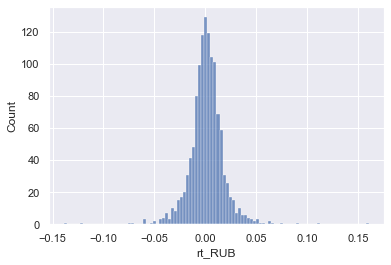

In [58]:
sns.histplot(data=ds, x='rt_RUB')
plt.show();

- On 23/02/2022:

In [59]:
ds['rt_RUB'][:ds[ds['Date'] == '2022-02-23'].index[0]].quantile(q=1-alpha)

0.04286751119894201

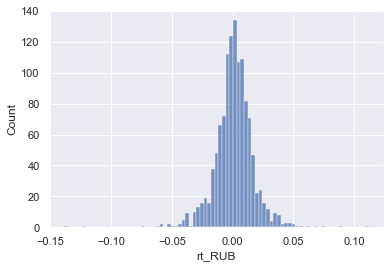

In [60]:
sns.histplot(data=ds[:ds[ds['Date'] == '2022-02-23'].index[0]], x='rt_RUB')
plt.show();                     

__EWMA Returns Distribution__
Class 4, page:13.

- On 09/03/2022

In [61]:
ds["rt_RUB_weight"] = 0 
ds["rt_RUB_weight"].iloc[ds.shape[0]-1] = 1-lbd

In [62]:
for i in range(2,ds.shape[0]):
    ds["rt_RUB_weight"].iloc[ds.shape[0]-i] = lbd*ds["rt_RUB_weight"].iloc[ds.shape[0]-i+1]

In [63]:
ds_hist_ewma = ds[["rt_RUB", "rt_RUB_weight"]].sort_values(by="rt_RUB")

In [64]:
ds_hist_ewma["Cumulative Probability"]=0
ds_hist_ewma["Cumulative Probability"].iloc[0] = ds_hist_ewma["rt_RUB_weight"].iloc[0]

for i in range(1,ds.shape[0]):
    ds_hist_ewma["Cumulative Probability"].iloc[i] = ds_hist_ewma["rt_RUB_weight"].iloc[i] + ds_hist_ewma["Cumulative Probability"].iloc[i-1]

In [65]:
ds_hist_ewma["Cumulative Probability"].quantile(q=1-alpha, interpolation="nearest")

0.864517195818307

In [66]:
# Finding the index of the quantile.

s = ds_hist_ewma['Cumulative Probability']
s[s == s.quantile(1-alpha, interpolation='lower')].index

Int64Index([1224], dtype='int64')

In [67]:
print("The value of the historical Var is equal to:", ds_hist_ewma["rt_RUB"].iloc[1224])

The value of the historical Var is equal to: 0.051948138611001955


- On 23/02/2022:

In [68]:
s = ds_hist_ewma['Cumulative Probability'][:ds[ds['Date'] == '2022-02-23'].index[0]]
s[s == s.quantile(1-alpha, interpolation='lower')].index

Int64Index([843], dtype='int64')

In [69]:
print("The value of the historical Var is equal to:", ds_hist_ewma["rt_RUB"].iloc[843])

The value of the historical Var is equal to: 0.007364074378308463


__Historical VaR with Volatility Weighting Methodology__

In [70]:
ds['Return_Adjusted_Variance'] = 0
ds['Return_Adjusted_Variance'].iloc[0] = (ds['rt_RUB']*ds['rt_RUB']).mean()

In [71]:
for i in range(1,ds.shape[0]):
    ds.loc[i, 'Return_Adjusted_Variance'] = (1-lbd)*ds.loc[i-1, 'rt_RUB']*ds.loc[i-1, 'rt_RUB'] + lbd*ds.loc[i-1, 'Return_Adjusted_Variance']

In [72]:
ds['Return_Adjusted Volatility'] = np.sqrt(ds['Return_Adjusted_Variance'])

In [73]:
# The adjusted returns.

ds['Adjusted_rt_RUB'] = ds['rt_RUB'] \
                *(ds.loc[ds.shape[0]-1, 'Return_Adjusted Volatility']/ds['Return_Adjusted Volatility'])

- on the 09/03/2022

In [74]:
ds['Adjusted_rt_RUB'].quantile(q=1-alpha)

0.11092336741167963

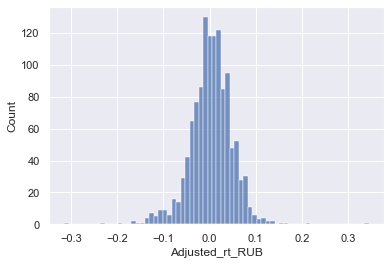

In [75]:
sns.histplot(data=ds, x='Adjusted_rt_RUB')
plt.show();

- On 23/02/2022.

In [76]:
ds['Adjusted_rt_RUB'][:ds[ds['Date'] == '2022-02-23'].index[0]].quantile(q=1-alpha)

0.10595940110254003

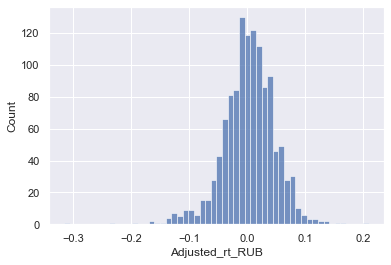

In [77]:
sns.histplot(data=ds[:ds[ds['Date'] == '2022-02-23'].index[0]], x='Adjusted_rt_RUB')
plt.show();                     

In [78]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1))

time taken to run: 25.361669900000003
